In [105]:
import pygplates
import numpy as np
import pandas as pd
import healpy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpltools import style
from mpltools import layout
%matplotlib inline

In [27]:
def create_gpml_velocity_feature(longitude_array,latitude_array,filename=None,feature_type=None):
# function to make a velocity mesh nodes at an arbitrary set of points
# Long and Lat are assumed to be 1d arrays. 

    multi_point = pygplates.MultiPointOnSphere(zip(latitude_array,longitude_array))

    # Create a feature containing the multipoint feature. 
    # optionally, define as 'MeshNode' type, so that GPlates will recognise it as a velocity layer
    if feature_type=='MeshNode':
        meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
        meshnode_feature.set_name('Velocity Mesh Nodes')
    else:
        meshnode_feature = pygplates.Feature()
        meshnode_feature.set_name('Multipoint Feature')
    
    meshnode_feature.set_geometry(multi_point)
    
    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    if filename is not None:
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

In [28]:
def create_gpml_healpix_mesh(nSide,filename=None,feature_type=None):

    # call the function to create a healpix array
    #nSide = 32
    othetas,ophis = healpy.pix2ang(nSide,np.arange(12*nSide**2))
    othetas = np.pi/2-othetas
    ophis[ophis>np.pi] -= np.pi*2

    lats = np.degrees(othetas) 
    lons = np.degrees(ophis)

    # call the function to create a multipoint feature, with user-defined type
    output_feature_collection = create_gpml_velocity_feature(lons,lats,filename,feature_type)

    if filename is not None:  # This is superfluous, since file has already been written in previous line???
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

In [30]:
basedir = '/Users/Andrew/Documents/PhD/Models/1000-410_Models/ANS_model/ANS_current'

In [31]:
rotation_model = pygplates.RotationModel('%s/1000-410_rotations(finished)_20171004_merge.rot' % basedir)
polygons = pygplates.FeatureCollection('%s/Neoproterozoic_Palaeozoic_Shapes_20170714_new-antarctica.gpml' % basedir)

In [29]:
#create equal area mesh
latlon_mesh = create_gpml_healpix_mesh(32)

In [54]:
#extract mesh lat-lon data to make sure it was created properly, and to get the number of points
pt_lon = []
pt_lat = []

for i in latlon_mesh:
    for point in i.get_geometry():
        pt_lon.append(point.to_lat_lon()[1])
        pt_lat.append(point.to_lat_lon()[0])
#        print point.to_lat_lon()[0]

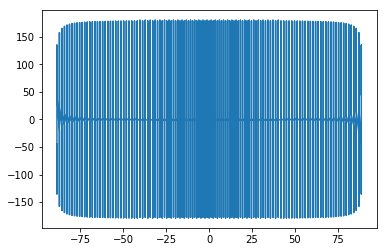

In [58]:
#test our mesh to see what it looks like
plt.plot(pt_lat, pt_lon)

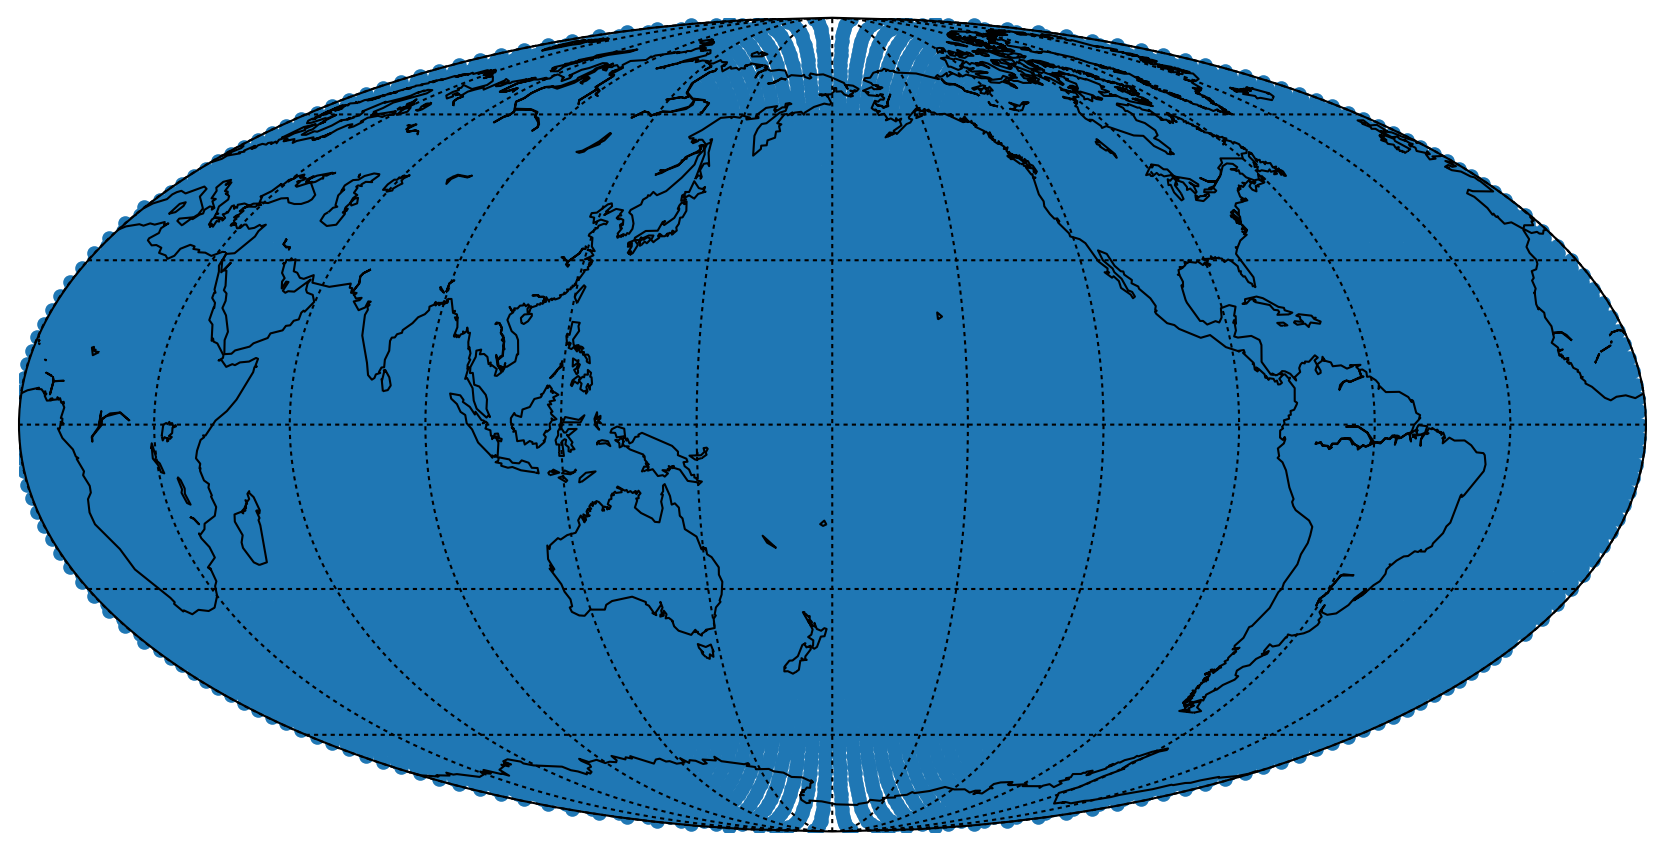

In [68]:
#test our mesh to see what it looks like no. 2

fig = plt.figure(figsize=(14,10),dpi=150)
m = Basemap(projection='moll', lon_0=180, resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30))
m.drawmeridians(np.arange(-180,180,30))

x,y = m(pt_lon,pt_lat)
im = m.scatter(x,y)

In [ ]:
#we want to bin data into 5° latitudes, setting up bins and how much area each point covers here

#create bins
bins = np.linspace(-90,90,185/5)

#area covered by each point
number_of_points = len(pt_lat)
print 'number of points', len(pt_lat)

#surface area of the earth
r = 6371
surface_area = 4 * np.pi * r ** 2
print 'surface area of the earth', surface_area

area_per_point = surface_area/number_of_points

print 'area per point', area_per_point


In [101]:
# Resolve our topological plate polygons (and deforming networks) to the current 'time'.

num_time_steps = 1000
anchor_plate = 0

latitude_points = []
latlon_array = []

for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())

for time in range(520, num_time_steps + 10,10):
    
    tmp_lat_points = []
    reconstructed_features = []
    
    pygplates.reconstruct(polygons, 
                          rotation_model, 
                          reconstructed_features, 
                          time, 
                          anchor_plate)

    for poly in reconstructed_features:
        poly_geom = poly.get_reconstructed_geometry()
        #print poly_geom
        for i in latlon_array:
            if poly_geom.is_point_in_polygon(i):
                #print i[0]
                tmp_lat_points.append(i[0])
    tmp_data = np.histogram(tmp_lat_points, bins)
    tmp_area = tmp_data[0] * area_per_point
    latitude_points.append(tmp_area)

In [103]:
#save data as a csv
np.savetxt('cont_area_vs_lat.csv', latitude_points, delimiter=',')

In [33]:
times = range(520, num_time_steps + 10,10)
lats = latitude_points

#plotting params
width=9
axes_title_fontsize = 40
tick_fontsize = 20
title_fontsize = 40
major_ticks = np.arange(-90, 91, 30) 

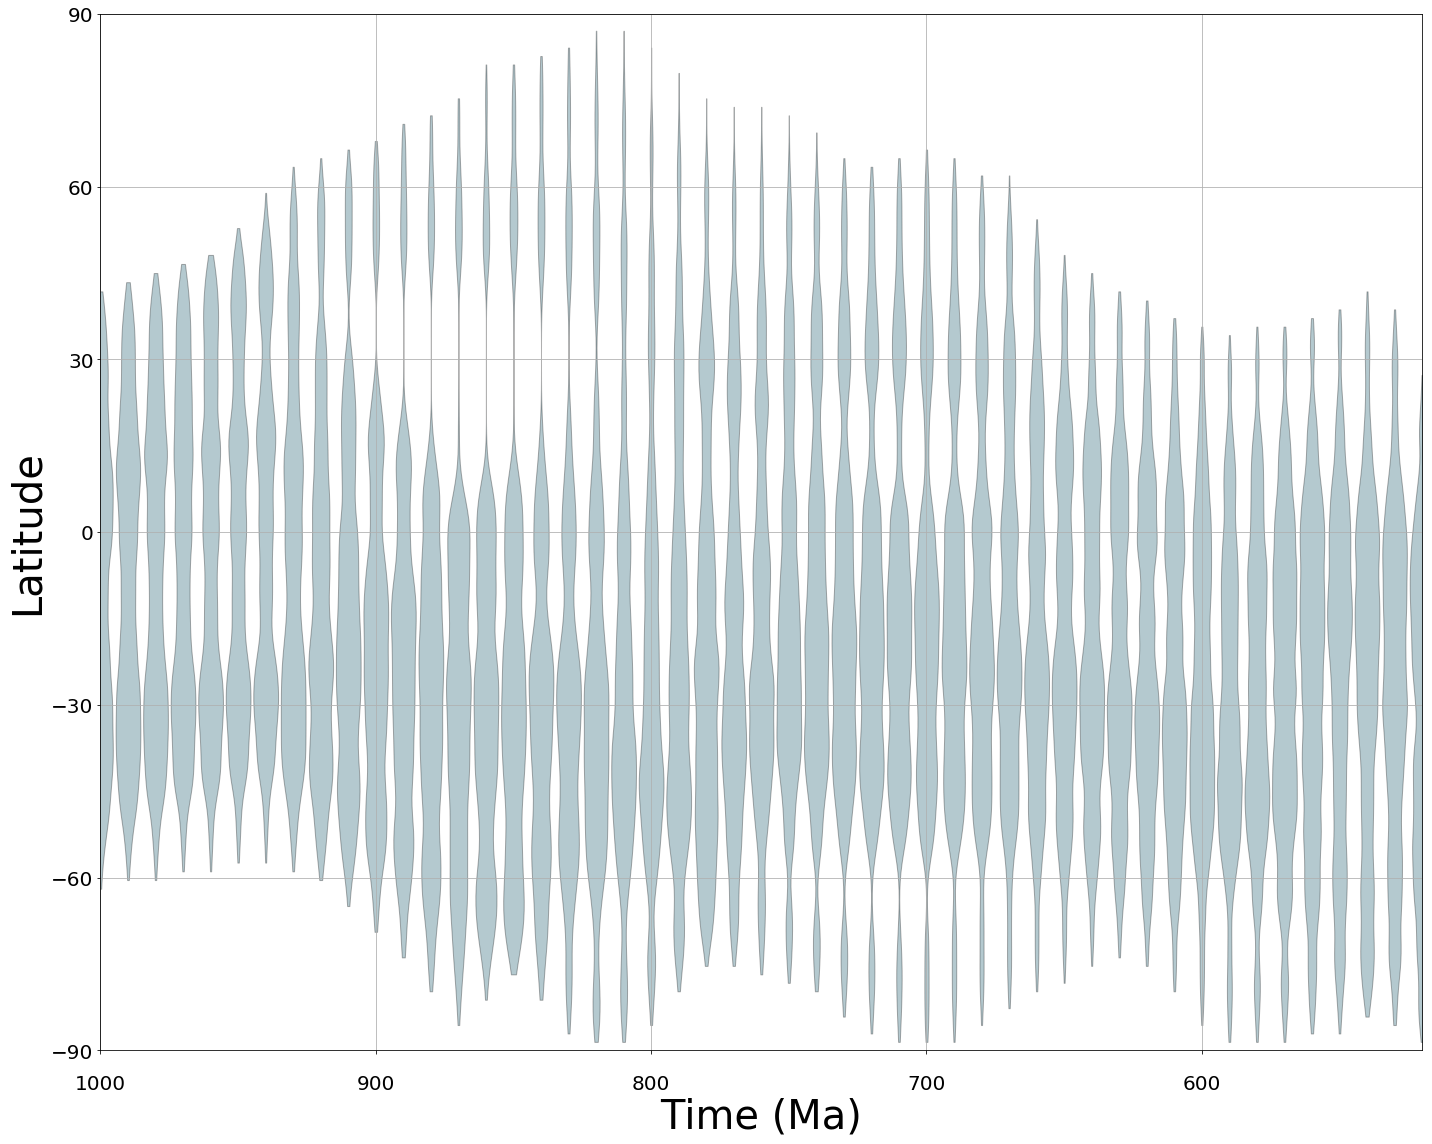

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,16),facecolor='w', edgecolor='k')

vp = axes.violinplot(lats,times,widths=width,bw_method=0.1,showextrema=False)
axes.set_xlim(1000,520)
axes.set_ylim(-90,90)
axes.set_ylabel('Latitude', fontsize=axes_title_fontsize)
axes.set_xlabel('Time (Ma)', fontsize=axes_title_fontsize)
axes.tick_params(axis='y', labelsize=tick_fontsize)
axes.tick_params(axis='x', labelsize=tick_fontsize, pad=20)
axes.set_yticks(major_ticks)
axes.grid(True)

#set colouring
for pc in vp['bodies']:
    pc.set_facecolor('#084c61')
    pc.set_edgecolor('black')

plt.tight_layout()
plt.savefig('Subduction_palaeolatitude.svg', bbox_inches='tight')